# Install packages

In [ ]:
%pip install pdnl_sana
%pip install nibabel
%pip install lxml
%pip install pandas

import os
import sys

import nibabel as nib
from lxml import objectify
import numpy as np
from matplotlib import pyplot as plt
import cv2
import pandas as pd

import pdnl_sana as sana
import pdnl_sana.geo
import pdnl_sana.interpolate
import pdnl_sana.image
import pdnl_sana.color_deconvolution


Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
  Using cached pyqt6_sip-13.10.2-cp39-cp39-macosx_10_9_universal2.whl.metadata (494 bytes)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.2/60.2 MB 44.9 MB/s  0:00:01 eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.3/62.3 MB 30.7 MB/s  0:00:02 eta 0:00:01
Using cached pyqt6_sip-13.10.2-cp39-cp39-macosx_10_9_universal2.whl (110 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3/3 [pyqt6]32m2/3 [pyqt6]
Note: you may need to restart the kernel to use updated packages.


# Initialize data source

In [120]:

# location of the data
version = "v1"
drive = os.path.join("data", version)
# drive = "./for_noah/data"
rois = sorted([x for x in os.listdir(drive) if x != '.DS_Store'])
print("ROIs:", rois)

# types of images to analyze
sources = ['meguro', 'mri']

# example ROI
print(os.path.join(drive, rois[0]))
for f in os.listdir(os.path.join(drive, rois[0])):
    print('\t', f)

ROIs: ['A. Patient #1 naPPA, BA8', 'B. Patient #2 naPPA, BA8', 'C. Patient #3 naPPA, BA8', 'D. Patient #4 naPPA, BA8', 'E. Patient #5 svPPA, BA20', 'F. Patient #6 HC, BA8', 'G. Patient #6 HC, BA20']
data/v1/A. Patient #1 naPPA, BA8
	 at8.annot
	 .DS_Store
	 mri.annot
	 lfb.nii.gz
	 mri.nii.gz
	 old.annot
	 meguro.annot
	 meguro.nii.gz
	 lfb.annot
	 at8.nii.gz


# Functions for I/O

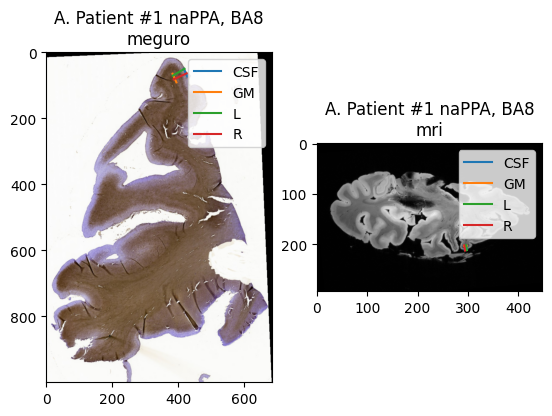

In [121]:

# parses the sform matrix from the header for converting annotation vector to points in the image
def load_sform(f):
    nifti = nib.load(f)
    sform = np.zeros([3,3], dtype=float)
    for i, ax in enumerate(['x', 'y', 'z']):
        sform[i] = nifti.header[f'srow_{ax}'][:3]
    return sform
    
# nifti I/O
def load_nifti_img(f):
    nifti = nib.load(f)
    img = np.asanyarray(nifti.dataobj)
    if type(img.dtype) is np.dtypes.VoidDType:
        img = img.view((img.dtype[0], len(img.dtype.names)))
    img = np.squeeze(img)
    if len(img.shape) == 2:
        img = img[:,:,None]
    else:
        img = img.transpose(1,0,2)

    return img

# parse the lxml file
def load_itksnap_annotations(f):
    
    tree = objectify.fromstring(open(f, 'rb').read())
    annotations = tree.folder.getchildren()

    annos = []
    for annotation in annotations:
        if annotation.get('key') == 'ArraySize':
            continue
    
        # load the Position (voxel) and Offset (mm)
        pos, offset, label, plane = None, None, None, None
        for x in annotation.getchildren():
            if x.get('key') == 'Text':
                label = x.get('value')
            if x.get('key') == 'Plane':
                plane = int(x.get('value'))
            if x.get('key') == 'Pos':
                pos = np.array(list(map(float, x.get('value').split(' '))))
            if x.get('key') == 'Offset':
                offset = np.array(list(map(float, x.get('value').split(' '))))
        annos.append([label, plane, pos, offset])
        
    return annos                

# handles the coordinate changes in the 3D space
def load_itksnap_ihc_annotations(f, sform):

    annotations = load_itksnap_annotations(f)
    annos = {}
    for label, plane, pos, offset in annotations:

        # grab the slice number to extract
        slice_num = int(np.ceil(pos[plane]))

        # invert direction of the anno vector
        offset[1] *= -1

        # make the offset 3D
        offset = np.insert(offset, 2, 0)

        # calculate the start and end points of the annotation
        p0 = np.linalg.inv(sform) @ (sform @ pos)
        p1 = (np.linalg.inv(sform) @ ((sform @ pos) - offset))

        # remove the z axis
        p0 = np.delete(p0, plane)
        p1 = np.delete(p1, plane)

        # store the (x,y) annotation
        annos[label] = sana.geo.Curve([p0[0], p1[0]], [p0[1], p1[1]])

    # parse the annotation labels into a common label set
    segments = {
        'CSF': annos['gm'],
        'GM': annos['wm'],
        'L': annos['left'],
        'R': annos['right'],
    }

    return segments

# handles the coordinate changes in the 2D space
def load_itksnap_mri_annotations(f, sform, version):

    annotations = load_itksnap_annotations(f)
    annos = {}
    for label, plane, pos, offset in annotations:
        
        # grab the slice number to extract
        slice_num = int(np.ceil(pos[plane]))

        # invert direction of the anno vector
        offset[1] *= -1

        # make the offset 3D
        if pos[1] < 1 and version == "v1":
            offset = np.insert(offset, 0, 0)
        else:
            offset = np.insert(offset, 1, 0)

        # calculate the start and end points of the annotation
        p0 = np.linalg.inv(sform) @ (sform @ pos)
        p1 = (np.linalg.inv(sform) @ ((sform @ pos) - offset))

        # remove the z axis
        p0 = np.delete(pos, plane)
        p1 = np.delete(p1, plane)

        # store the (y,x) annotation
        annos[label] = sana.geo.Curve([p0[0], p1[0]], [p0[1], p1[1]])

        # convert to (x,y) annotation
        annos[label] = annos[label][:, ::-1]

    # parse the annotation labels into a common label set
    segments = {
        'CSF': annos['gm'],
        'GM': annos['wm'],
        'L': annos['left'],
        'R': annos['right'],
    }

    # NOTE: we're just assuming that all annotations are in the same plane/slice_num
    return segments

# load the images and annotations for a given ROI
def load_data(version, roi, source, ax=None):
    drive = os.path.join("data", version)

    anno_f = os.path.join(drive, roi, f'{source}.annot')
    img_f = os.path.join(drive, roi, f'{source}.nii.gz')
    
    sform = load_sform(img_f)
    if source == 'mri':
        annos = load_itksnap_mri_annotations(anno_f, sform, version)
    else:
        annos = load_itksnap_ihc_annotations(anno_f, sform)
    img = load_nifti_img(img_f)

    if not ax is None:
        _ = ax.imshow(img, cmap='gray')
        _ = [ax.plot(*annos[label].T, label=label) for label in annos]
        _ = ax.legend()
        _ = ax.set_title(f'{roi}\n{source}')

    return img, annos

# test the I/O
version = "v2"
fig, axs = plt.subplots(1,2)
roi = 'A. Patient #1 naPPA, BA8'
img, annos = load_data(version, roi, source='meguro', ax=axs[0])
img, annos = load_data(version, roi, source='mri', ax=axs[1])


# Correlation Analysis

In [122]:

aspect_ratio = 0.66
h = 40
w = int(40*aspect_ratio)

def resample_rois(version):
    drive = os.path.join("data", version)

    rois = sorted([x for x in os.listdir(drive) if x != '.DS_Store'])

    data = {}
    for i, roi in enumerate(rois):
        data[roi] = {}

        # load the data
        fig, axs = plt.subplots(1, len(sources), figsize=(20,10))
        for j, source in enumerate(sources):
            img, annos = load_data(version, roi, source, ax=axs[j])
            data[roi][source] = [img, annos]

        fig.tight_layout()
        plt.savefig(os.path.join('output', version, f'{roi}_01_thumbnails.png'))
        plt.close()

        # apply the resampling
        fig, axs = plt.subplots(1, len(sources), figsize=(20,10))
        for j, source in enumerate(sources):
            img, annos = data[roi][source][:2]

            sample_grid, _ = sana.interpolate.fan_sample(annos['CSF'], annos['R'], annos['GM'], annos['L'])
            resampled = sana.interpolate.grid_sample(sana.image.Frame(img.copy(), level=0), sample_grid)
            resampled.resize(sana.geo.Point(w, h, level=0), interpolation=cv2.INTER_LINEAR)

            data[roi][source] = (img, annos, resampled)
            
            axs[j].imshow(resampled.img, cmap='gray')
            axs[j].set_title(f'{source}')

        fig.suptitle(f'{roi}')

        fig.tight_layout()
        plt.savefig(os.path.join('output', version, f'{roi}_02_resampled.png'))
        plt.close()

    return data

def find_correlation(version):
    data = {}
    data = resample_rois(version)
    
    df = []

    fig, axs = plt.subplots(len(data),len(sources)+1, figsize=(8,20), sharey=True)

    for i, roi in enumerate(rois):
        ax_signals = axs[i,2]

        signals = []
        for j, source in enumerate(sources):
            img, annos, resampled = data[roi][source]
        
            if source == 'mri':
                target = resampled.img[:,:,0]

            # convert the RGB IHC data to grayscale using color deconvolution
            else:
                if source == 'lfb':
                    ss = sana.color_deconvolution.StainSeparator('LFB-CV')
                    stains = ss.separate(resampled.img)
                    target = stains[:,:,0]
                else:
                    ss = sana.color_deconvolution.StainSeparator('H-DAB')
                    stains = ss.separate(resampled.img)
                    target = stains[:,:,1]

            axs[i][j].imshow(target, cmap='gray', extent=(0, 2.64, -2, 2))
            axs[i][j].set_title(source.replace('meguro', 'Iron Stain').replace('mri', 'MRI T2*w'))
            axs[i][j].axis('off')

            # signal standardization 
            target = (target - np.mean(target)) / np.std(target)
            signal = np.median(target, axis=1)[5:]
            signals.append(signal)
            
            ax_signals.plot(np.linspace(0, 1, len(signal)), signal, label=source.replace('meguro', 'Iron Stain').replace('mri', 'MRI T2*w'), linewidth=3)
            ax_signals.legend(loc='center left', bbox_to_anchor=(.8, 0.5))
            ax_signals.set_xlabel('Cortical Depth')
            ax_signals.set_ylabel('Standardized Intensity')
            ax_signals.set_xticks([0, 0.25, 0.5, 0.75, 1.0])
            ax_signals.axhline(0, color='black')
            ax_signals.set_ylim([-2,2])
            ax_signals.set_xlim([0,1])

        # calculate and store the correlation between IHC and MRI
        X_signal = signals[-1]
        Y_signal = signals[0]
        R = np.corrcoef(X_signal, Y_signal)[0][1]
        ax_signals.set_title(roi+' | '+r"$R=%.2f$" % (R), loc="left")
        ax_signals.set_yticks([-2, -1, 0, 1, 2])
        ax_signals.set_xticks([0, 0.25, 0.50, 0.75, 1.0])

        df.append({
            'ROI': roi, 
            f'R_{version}': R,
        })

    fig.tight_layout()
    plt.savefig(os.path.join('output', f'final_figure_{version}.png'))
    plt.close()
    
    df = pd.DataFrame(df)

    return df

df_v1 = find_correlation("v1")
df_v2 = find_correlation("v2") 
df = df_v1.merge(df_v2, on='ROI')
df.to_csv(os.path.join('output', 'correlations.csv'), index=False)
print(df)
    

                         ROI      R_v1      R_v2
0   A. Patient #1 naPPA, BA8 -0.759428 -0.868074
1   B. Patient #2 naPPA, BA8 -0.651711 -0.967395
2   C. Patient #3 naPPA, BA8 -0.855498 -0.765700
3   D. Patient #4 naPPA, BA8 -0.765073 -0.885478
4  E. Patient #5 svPPA, BA20 -0.539477 -0.848233
5      F. Patient #6 HC, BA8 -0.964789 -0.973175
6     G. Patient #6 HC, BA20 -0.952006 -0.967206
